In [2]:
import pandas as pd
import osmnx as ox
import matplotlib.pyplot as plt
import json
from sqlalchemy.orm import subqueryload
from sqlalchemy_bigquery import WKT
from shapely.geometry import Point
from sqlalchemy import select, func, Boolean, text
from geoalchemy2.shape import from_shape, to_shape
import shapely
import numpy

from src.database.models import *
from src.database.base import *

In [4]:
# bound = {"x1": 56.222, "y1": 43.894, "x2": 56.429, "y2": 44.086}
session = AsyncSessionMaker()
cnt = 20000
last_city = None
pops = []
# df = pd.read_csv("file.csv", nrows=cnt)
# print(df)

SIZE = 0.0083333
M = 1


def create_poly(poly, size: int):
    left_bottom = (poly.x - size * M / 2, poly.y - size / 2)
    left_top = (left_bottom[0], left_bottom[1] + size)
    right_top = (left_top[0] + size * M, left_top[1])
    right_bottom = (right_top[0], right_top[1] - size)
    coords = (left_bottom, left_top, right_top, right_bottom)
    return shapely.Polygon(coords)


async def get_city(p):
    stmt = (
        select(City).filter(func.ST_Intersects(City.geometry, from_shape(p))).limit(1)
    )
    result = await session.execute(stmt)
    return result.scalar_one_or_none()


async def in_bound(p):
    c = None
    global last_city
    if last_city:
        g = to_shape(last_city.geometry)
        if g.contains(p):
            c = last_city
        else:
            city = await get_city(p)
            if city:
                last_city = city
                c = last_city

    else:
        city = await get_city(p)
        if city:
            last_city = city
            c = last_city
    return c


iter = 0
for chunk in pd.read_csv("ukr_file.csv", chunksize=cnt):
    iter += 1
    for c in chunk.itertuples():
        if c.Z >= 3:
            p = Point(c.X, c.Y)
            ci = await in_bound(p)
            if ci:
                location = WKT(p.wkt)
                poly = create_poly(p, SIZE)
                geometry = WKT(poly.wkt)
                pop = Population(
                    location=location, geometry=geometry, value=c.Z, city=ci
                )
                pops.append(pop)
    print(iter * cnt, len(pops))

session.add_all(pops)
await session.commit()

20000 0
40000 0
60000 0
80000 0
100000 11
120000 11
140000 11
160000 11
180000 11
200000 11
220000 11
240000 15
260000 16
280000 16
300000 16
320000 16
340000 44
360000 47
380000 48
400000 48
420000 59
440000 150
460000 203
480000 230
500000 272
520000 302
540000 310
560000 459
580000 612
600000 812
620000 867
640000 1042
660000 1499
680000 1949
700000 2182
720000 2427
740000 2838
760000 2953
780000 3506
800000 4439
820000 5095
840000 5391
860000 5497
880000 5751
900000 6064
920000 6457
940000 6536
960000 7067
980000 7271
1000000 7380
1020000 9419
1040000 11554
1060000 14832


In [ ]:
# import math

SIZE = 0.0083333
M = 1


def create_poly(poly: dict, size: int):
    left_bottom = (poly.x - size * M / 2, poly.y - size / 2)
    left_top = (left_bottom[0], left_bottom[1] + size)
    right_top = (left_top[0] + size * M, left_top[1])
    right_bottom = (right_top[0], right_top[1] - size)
    coords = (left_bottom, left_top, right_top, right_bottom)
    return shapely.Polygon(coords)


session = AsyncSessionMaker()
result = await session.execute(select(City))
cities = result.scalars()


for city in cities:
    result = await session.execute(
        select(Population).where(Population.city_id == city.id)
    )
    populations = result.scalars()
    populations = [p for p in populations]
    if len(populations) == 0:
        continue

    for population in populations:
        p = to_shape(population.location)
        poly = create_poly(p, SIZE)
        geometry = WKT(poly.wkt)
        population.geometry = geometry

    session.add_all(populations)
    await session.commit()
    print(city.name)
    # min_r = 1234567890000123456789345678
    # for i in range(l_p):
    #     p_i = to_shape(populations[i].location)
    #     for j in range(i + 1, l_p):
    #         p_j = to_shape(populations[j].location)
    #         r = math.hypot(p_i.x - p_j.x, p_i.y - p_j.y)
    #         if r < min_r:
    #             min_r = r
    # print(min_r)

In [9]:
with open("parking_NN.json", encoding="utf-8") as file:
    data = json.load(file)

session = AsyncSessionMaker()
result = await session.execute(select(City).where(City.id == 1391))
city = result.scalar()
parkings = data["features"]
parks = []

geometry = to_shape(city.geometry)


for p in parkings:
    prop = p["properties"]
    point = Point(p["geometry"]["coordinates"][0], p["geometry"]["coordinates"][1])

    if not geometry.contains(point):
        continue
    location = WKT(
        Point(p["geometry"]["coordinates"][0], p["geometry"]["coordinates"][1]).wkt
    )
    left_bottom = (prop["boundedBy"][0][0], prop["boundedBy"][0][1])
    left_top = (prop["boundedBy"][0][0], prop["boundedBy"][1][1])
    right_top = (prop["boundedBy"][1][0], prop["boundedBy"][1][1])
    right_bottom = (prop["boundedBy"][1][0], prop["boundedBy"][0][1])
    coords = (left_bottom, left_top, right_top, right_bottom)
    park = Parking(
        description=prop["description"],
        address=prop["CompanyMetaData"]["address"],
        location=location,
        city_id=1391,
    )
    parks.append(park)

session.add_all(parks)
await session.commit()

In [5]:
from sqlalchemy import String, Integer


session = AsyncSessionMaker()
with open("ev_load_new.json", encoding="utf-8") as file:
    data = json.load(file)
stations = data["stations"]

for s in stations:
    result = await session.execute(
        select(EVStation).filter(
            EVStation.address["Title"].as_string().cast(String) == s["name"]
            if "name" in s
            else EVStation.external_id["id"].as_string().cast(Integer) == s["osm_id"],
            EVStation.city_id == s["city_id"],
        )
    )
    ev = result.scalar()

    values = []
    for w in s["weekdays"].values():
        value_w = 0
        for _, v in w.items():
            value_w += v
        values.append(value_w)
    try:
        ev.use_time = numpy.median(values)
    except:
        print(s["name"])
await session.commit()

EVT 380
ЖК Ол Инклюзив
GREEN DRIVE САНАТОРИЙ БЕЛАРУСЬ СОЧИ


In [3]:
session = AsyncSessionMaker()


session.add_all(
    [
        EVLoad(min_pop=0, max_pop=10000, value=2),
        EVLoad(min_pop=10000, max_pop=100000, value=4),
        EVLoad(min_pop=100000, max_pop=1000000, value=6),
        EVLoad(min_pop=1000000, max_pop=100000000, value=10),
    ]
)
await session.commit()

In [1]:
import json
import numpy

with open("ev_load_new.json", encoding="utf-8") as file:
    data = json.load(file)


stations = data["stations"]

res = {1: [], 2: [], 3: [], 4: []}
for s in stations:
    values = []
    for w in s["weekdays"].values():
        value_w = 0
        for _, v in w.items():
            value_w += v
        values.append(value_w)
    res[s["id"]].append(numpy.median(values))
for id, values in res.items():
    print(id, numpy.median(values))

1 1.0
2 0.6
3 3.499999999999999
4 6.799999999999999


In [3]:
session = AsyncSessionMaker()

result = await session.execute(
        select(EVStation)
    )
for ev in result.scalars():
    ev.use_time=None
await session.commit()


In [4]:
import os
import json
from sqlalchemy_bigquery import WKT
from shapely.geometry import Point
from src.database.models import *
from src.database.base import *

session = AsyncSessionMaker()
root = "d_p_i"
parkings = []
for item in os.listdir(root):
    path_item = root + "\\" + item
    with open(path_item, encoding="utf-8") as file:
        data = json.load(file)
        city_id = int(item.split(".")[0])
        for parking in data:
            location = WKT(Point(parking["x"], parking["y"]).wkt)
            p = Parking(city_id=city_id, location=location)
            parkings.append(p)
session.add_all(parkings)
await session.commit()

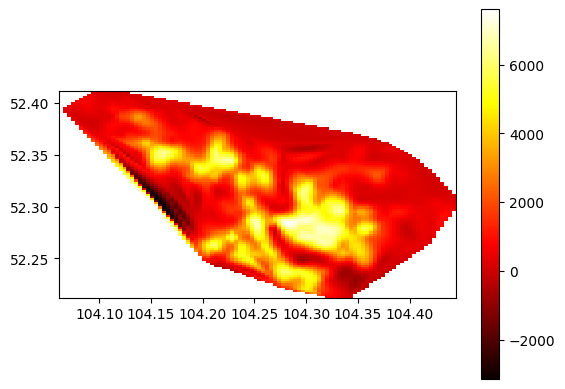

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

session = AsyncSessionMaker()
result = await session.execute(select(Population).filter(Population.city_id == 1391))
evs = result.scalars()

x = []
y = []
values = []
# Заполняем сетку значениями из объектов
for obj in evs:
    loc = to_shape(obj.location)
    x.append(loc.x)
    y.append(loc.y)
    values.append(obj.value)

# Создаем равномерную сетку значений
grid_x, grid_y = np.mgrid[min(x) : max(x) : 100j, min(y) : max(y) : 100j]

# Интерполируем значения на сетке
grid_z = griddata((x, y), values, (grid_x, grid_y), method="cubic")

# Строим тепловую карту
plt.imshow(
    grid_z.T,
    extent=(min(x), max(x), min(y), max(y)),
    origin="lower",
    cmap="hot",
    interpolation="nearest",
)
plt.colorbar()
plt.show()

In [10]:
from copy import copy


session = AsyncSessionMaker()



result = await session.execute(select(EVStation))



evs = result.scalars()


statuses = {
    "Временно недоступен": "Временно недоступна",
    "Запланированная на будущее дата": "Запланированна на будущее",
    "Не работает": "Не работает",
    "Неизвестно": "Неизвестно",
    "Оперативный": "Работает",
    "Частично действующий (смешанный)": "Частично действующая",
}


for ev in evs:
    # status = copy(ev.status_type)
    # status["Title"] = statuses[ev.status_type["Title"]]
    # ev.status_type = status

    # a = {}

    # addr = None

    # if "Title" in ev.address:

    #     a["title"] = ev.address["Title"]

    # if "StateOrProvince" in ev.address:

    #     addr = ev.address["StateOrProvince"]

    # if "Town" in ev.address:

    #     if addr:

    #         addr += ", " + ev.address["Town"]

    #     else:

    #         addr = ev.address["Town"]

    # if "AddressLine2" in ev.address:

    #     if addr:

    #         addr += ", " + ev.address["AddressLine2"]

    #     else:

    #         addr = ev.address["AddressLine2"]

    # if "AddressLine1" in ev.address:

    #     if addr:

    #         addr += ", " + ev.address["AddressLine1"]

    #     else:

    #         addr = ev.address["AddressLine1"]

    # if "Postcode" in ev.address:

    #     if addr:

    #         addr += ", " + ev.address["Postcode"]

    #     else:

    #         addr = ev.address["Postcode"]

    # if addr:

    #     a["address"] = addr

    # ev.address = a



await session.commit()
# statuses

KeyError: 'Работает'

In [5]:
session = AsyncSessionMaker()
result = await session.execute(select(EVStation))
evs = result.scalars()

with open("proccessed_charges.json", encoding="utf-8") as file:
    data = json.load(file)

for ev in evs:
    p_ev = to_shape(ev.location)
    for d in data:
        p_d = Point(d["address"]["Longitude"], d["address"]["Latitude"])

        if p_ev == p_d:
            ev.address = d["address"]
# evs
await session.commit()